In [1]:
import tensorflow as tf

In [2]:
import keras

In [3]:
from keras.models import load_model

In [5]:
model = load_model('cats_and_dogs_small_1.h5')

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

# Preprocessing a single image

In [7]:
img_path = r'C:\Users\suvar\Desktop\DL\CatDog\cats_and_dogs_small\test\cats\cat.1513.jpg'
from keras.preprocessing import image # preprocesses the image into 4D tensor
import numpy as np

In [13]:
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
print(img_tensor.shape)

(150, 150, 3)


In [19]:
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


# Displaying the test picture

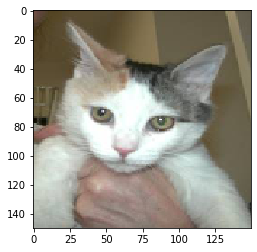

In [20]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

# Instantiating a model from an input tensor and a list of output tensors

In [22]:
from keras import models


In [26]:
model.layers[0].output

<tf.Tensor 'conv2d_4/Relu:0' shape=(None, 148, 148, 32) dtype=float32>

In [27]:
#Extracts the oputputs of top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs = layer_outputs)

In [28]:
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

In [29]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

# Visualizing the 4th channel

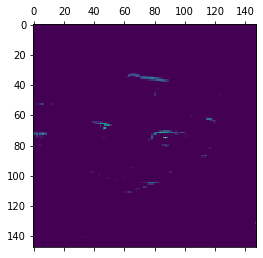

In [36]:
#It’s a 148 × 148 feature map with 32 channels, let's plot activation of1st layer of original model
plt.matshow(first_layer_activation[0, :, :, 4], cmap = 'viridis')
# so 4th channel useful to encode cat's eyes edges

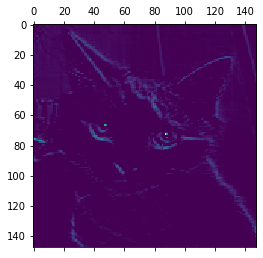

In [39]:
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis')

# Visualizing every channel in every intermediate activation

In [46]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] #The feature map has shape (1, size, size, n_features).
    size = layer_activation.shape[1]
    # below-tiles the activation channels in this matrix
    n_cols = n_features
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # tiles each feature into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

IndexError: index 32 is out of bounds for axis 3 with size 32

In [ ]:
#Higher presentations carry increasingly less information about the visual contents 
#of the image, and increasingly more information related to the class of the image.

# Defining the loss tensor  for filter visulization

In [47]:
from keras.applications import VGG16

In [48]:
from keras import backend as k
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = k.mean(layer_output[:,:,:, filter_index])


# Obtaining the gradient of the loss with regard to the input

In [52]:
grads = k.gradients(loss, model.input)[0]

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

# GRAD-CAM Visualization

In [53]:
from keras.applications import VGG16
model = VGG16(weights='imagenet')
#VGG16 model was trained on images of size 224*224

# Preprocessing an input image for VGG16 model

In [54]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [57]:
img_path = r'C:\Users\suvar\Desktop\DL\elephant.jpg'
img = image.load_img(img_path, target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # preprocesses the batch, channel-wise color normalization

In [58]:
preds = model.predict(x)
print('predicted: ', decode_predictions(preds, top=3)[0])

predicted:  [('n02504458', 'African_elephant', 0.89931923), ('n01871265', 'tusker', 0.07858104), ('n02408429', 'water_buffalo', 0.013289339)]


In [59]:
# top 3 classes predicted are african elephant - 89.9%, tusker -7.8% and water-buffalo - 1.3%
np.argmax(preds[0])

386

# GRAD -CAM Algo

In [60]:
# To visualize which parts of the image are the most African elephant–like, let’s set up the Grad-CAM process
african_elephant_output = model.output[:, 386] # African elephant entry in the prediction vector
# Output feature map of the block5_conv3 layer,the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')


In [61]:
african_elephant_output

<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>

In [64]:
# Gradient of the “African elephant” class with regard to the output feature map of block5_conv3 -175th page
grads = k.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = k.mean(grads, axis=(0,1,2))
iterate = k.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

ValueError: Tensor Tensor("Mean_1:0", shape=(512,), dtype=float32) is not an element of this graph.

In [63]:
tf.compat.v1.disable_eager_execution()